# Gerando Efeitos Digitais de Áudio

## Imports Iniciais

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

import sounddevice as sd
from ipywidgets import widgets
from pynput.keyboard import Key, Listener

import numpy as np
import pandas as pd
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

from time import *

In [13]:
import sys

In [28]:
fs = 44100
sd.default.samplerate = fs

In [29]:
fq = pd.read_csv('../utils/notesFrequencies',
                 index_col=0,
                 header=None,
                 names=['Note','Frequency','Wavelenght']).T
intervals = pd.read_csv('../utils/intervals',
                        header=None,
                        names = ['Semitone', 'R1', 'R2', 'Interval', 'Natural', 'HS1', 'HS2'])

## Definindo osciladores elementares

In [30]:
def sawtooth(frequency=220,duration=1,attackTime=0.05,decayTime=0.02,sustainLevel=0.8,releaseTime=0.3,fs=44100):
    wave=(signal.sawtooth(2*np.pi*frequency*np.linspace(0, duration, duration*fs))).astype(np.float32)
    #Attack
    wave[0:round(attackTime*fs)] *= attack(attackTime)
    #Decay
    wave[round(attackTime*fs):round((attackTime+decayTime)*fs)] *= decay(decayTime, sustainLevel)
    #Sustain
    wave[round((attackTime+decayTime)*fs):round((duration-releaseTime)*fs)] *= sustainLevel
    #Release
    wave[round((duration-releaseTime)*fs):round(duration*fs)] *= release(releaseTime, sustainLevel)
    return wave

def triangle(frequency=220,duration=1,attackTime=0.05,decayTime=0.05,sustainLevel=0.8,releaseTime=0.3,fs=44100):
    wave=(2*np.abs(signal.sawtooth(2*np.pi*frequency*np.linspace(0, duration, duration*fs)))-1).astype(np.float32)
    #Attack
    wave[0:round(attackTime*fs)] *= attack(attackTime)
    #Decay
    wave[round(attackTime*fs):round((attackTime+decayTime)*fs)] *= decay(decayTime, sustainLevel)
    #Sustain
    wave[round((attackTime+decayTime)*fs):round((duration-releaseTime)*fs)] *= sustainLevel
    #Release
    wave[round((duration-releaseTime)*fs):round(duration*fs)] *= release(releaseTime, sustainLevel)
    return wave
    
def square(frequency=220,duration=1,attackTime=0.05,decayTime=0.02,sustainLevel=0.8,releaseTime=0.3,fs=44100):
    
    #if not pwm: 
    wave=signal.square(2*np.pi*frequency*np.linspace(0, duration, round(duration*fs)))
    #else: 
    #    sig=((np.sin(2*np.pi*pwmFrequency*np.linspace(0, duration, round(duration*fs))) + 1)/2)
    #    wave=signal.square(2*np.pi*frequency*np.linspace(0, duration, round(duration*fs)),duty=sig)
    
    #Attack
    wave[0:round(attackTime*fs)] *= attack(attackTime)
    #Decay
    wave[round(attackTime*fs):round((attackTime+decayTime)*fs)] *= decay(decayTime, sustainLevel)
    #Sustain
    wave[round((attackTime+decayTime)*fs):round((duration-releaseTime)*fs)] *= sustainLevel
    #Release
    wave[round((duration-releaseTime)*fs):round(duration*fs)] *= release(releaseTime, sustainLevel)
    return wave

def sine(frequency=220,duration=1,attackTime=0.05,decayTime=0.02,sustainLevel=0.8,releaseTime=0.3,fs=44100):
    wave = (np.sin(2*np.pi*np.arange(duration*fs)*frequency/fs)).astype(np.float64)
    #Attack
    wave[0:round(attackTime*fs)] *= attack(attackTime)
    #Decay
    wave[round(attackTime*fs):round((attackTime+decayTime)*fs)] *= decay(decayTime, sustainLevel)
    #Sustain
    wave[round((attackTime+decayTime)*fs):round((duration-releaseTime)*fs)] *= sustainLevel
    #Release
    wave[round((duration-releaseTime)*fs):round(duration*fs)] *= release(releaseTime, sustainLevel)
    return wave

def noise(sigma=0.5,duration=1,fs=44100):
    return np.random.normal(0, sigma, round(duration*fs))

## Suavização de sinal

In [31]:
def smooth(x,window_len=15,window='hanning'):
    
    if x.ndim != 1: raise ValueError('Smooth only accepts 1 dimension arrays.')
    if x.size < window_len: raise ValueError('Input vector needs to be bigger than window size.')
    if window_len<3: return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': w=np.ones(window_len,'d')
    else: w=eval('np.'+window+'(window_len)')
    return np.convolve(w/w.sum(),s,mode='valid')

## Envelope ADSR

In [32]:
def attack(attackTime,fs=44100):
    x = np.linspace(-1,0,round(attackTime*fs))
    y = -(x**2)+1
    return y

def decay(decayTime,sustainLevel,fs=44100):
    x = np.linspace(-1,0,round(decayTime*fs))
    y = x**2*(1-sustainLevel) + sustainLevel
    return y

# Nível de sustain é definido diretamente na criação da onda.

def release(releaseTime,sustainLevel=1,fs=44100):
    x = np.linspace(-1,0,round(releaseTime*fs))
    y = x**4*sustainLevel
    return y

## LFO 

In [33]:
def lfo(wavetype='none',frequency=0,duration=0,fs=44100):
        if wavetype == 'none': return 1
        elif wavetype == 'sine': return abs(sine(frequency,duration,fs))
        elif wavetype == 'triangle': return triangle(frequency,duration,fs)
        elif wavetype == 'square': return square(frequency,duration,fs)
        elif wavetype == 'sawtooth': return sawtooth(frequency,duration,fs)

## Arpegiador

In [34]:
notes = [fq['C3'][0],fq['E3'][0],fq['G3'][0],fq['B3'][0],fq['C4'][0]]

In [35]:
def arpeggiator(notes,wavetype,delay,order,attackTime,decayTime,sustainLevel,releaseTime,fs=44100):
    
    waves, sound = list(), list()
    
    if wavetype == 'sine':
        if order == 'u':
            for note in notes:
                waves.append(sine(note,delay,attackTime,decayTime,sustainLevel,releaseTime,fs=44100))
            sound = np.concatenate(waves)    
            sd.play(sound)
            
        elif order == 'd':
            for note in notes[::-1]:
                waves.append(sine(note,delay,attackTime,decayTime,sustainLevel,releaseTime,fs=44100))
            sound = np.concatenate(waves)    
            sd.play(sound)
            
        elif order == 'ud':
            for note in notes:
                waves.append(sine(note,delay,attackTime,decayTime,sustainLevel,releaseTime,fs=44100))
            for note in (notes[::-1])[1:-1]:
                waves.append(sine(note,delay,attackTime,decayTime,sustainLevel,releaseTime,fs=44100)) 
            sound = np.concatenate(waves)
            sound = np.concatenate([sound,sound])
            sound = np.concatenate([sound,sound])
            sound = np.concatenate([sound,sound])
            sd.play(smooth(sound, window_len=80))
            
        elif order == 'rand':
            rand = notes.copy()
            for i in range(0,10):
                np.random.shuffle(rand)
                for note in rand:
                    waves.append(sine(note,delay,attackTime,decayTime,sustainLevel,releaseTime,fs=44100)) 
                sound = np.concatenate(waves)
            sd.play(sound)
                
        else: raise ValueError('Order must be u for up, d for down, ud for up and down or rand for random order.')

In [39]:
delayTerm = 0.005

arpeggiator(notes,'sine',0.2,'ud',0,0,0.6,0)

## Plotando o Sinal

In [16]:
duration = 2

fs = 44100

samples = list()
s = list()

s.append(square(200,duration=duration))
s.append(sawtooth(2,duration=duration))

for i in range(0,len(s)):
    samples.append(s[i])

result = samples[0]*samples[1]

In [17]:
# fourier fast transform
N = len(result)
T = 1.0 / fs
x = np.linspace(0.0, N*T, N)
y = result
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

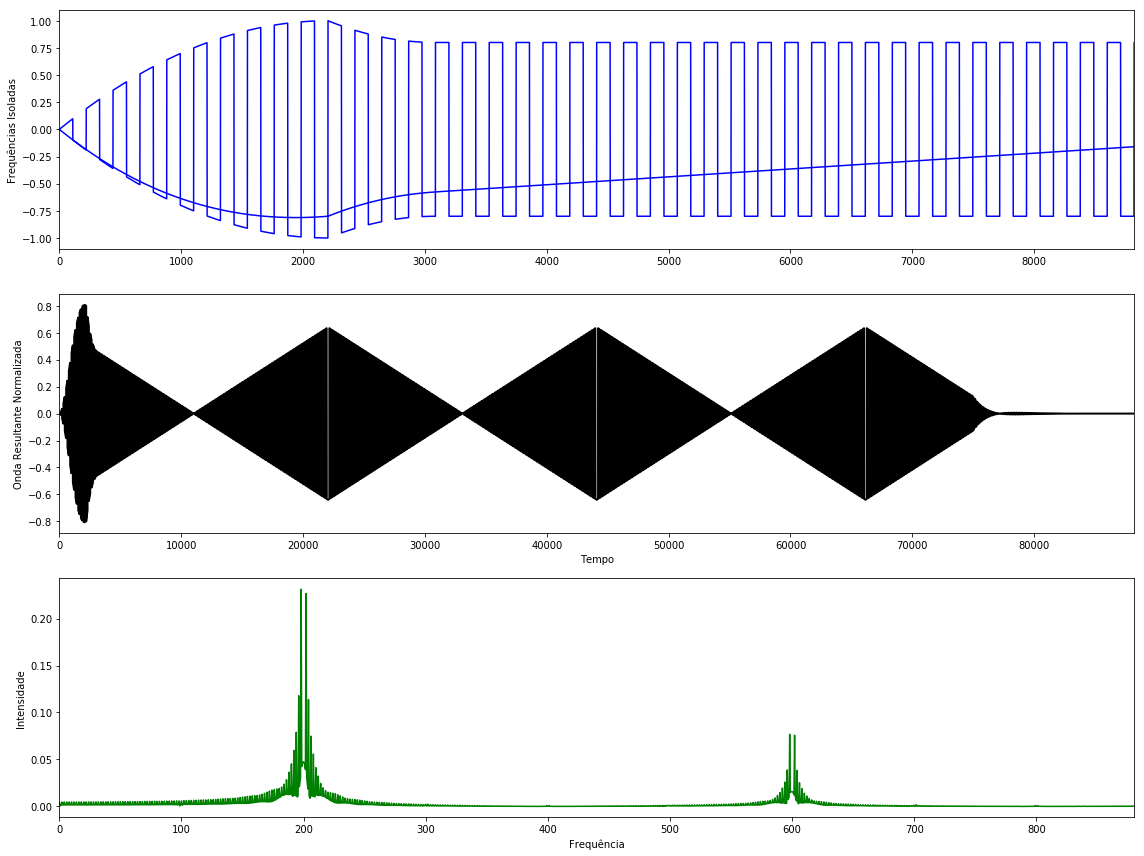

In [18]:
fig = plt.figure(figsize=(16, 12)) 
gs = gridspec.GridSpec(3, 1) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# plotando ondas separadas
for sample in samples:
    ax0.plot(range(0,len(sample)), sample, color = 'b')
ax0.set_ylabel('Frequências Isoladas')
ax0.set_xlim(0,fs/5)

# domínio tempo da onda resultante
ax1.plot(range(0,len(result)), result, color = 'black', linewidth=2)
ax1.set_xlabel('Tempo')
ax1.set_ylabel('Onda Resultante Normalizada')
ax1.set_xlim(0,fs*duration)

# domínio frequência da onda resultante
ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color = 'g')
ax2.set_xlim(0,880)
ax2.set_xlabel('Frequência')
ax2.set_ylabel('Intensidade')

fig.tight_layout();

In [20]:
sd.play(result)

## Botões

In [21]:
def frequencyWidget(Frequency):
    global frequency
    frequency = Frequency

def attackWidget(AttackTime):
    global attackTime
    attackTime = AttackTime
    
def decayWidget(DecayTime):
    global decayTime
    decayTime = DecayTime
    
def sustainWidget(SustainLevel):
    global sustainLevel
    sustainLevel = SustainLevel
    
def releaseWidget(ReleaseTime):
    global releaseTime
    releaseTime = ReleaseTime

In [1]:
widgets.interact(frequencyWidget, 
                 Frequency=widgets.FloatSlider(min=0.00001,
                                               max=900,
                                               step=0.01))
widgets.interact(attackWidget, 
                 AttackTime=widgets.FloatSlider(min=0.00001,
                                               max=1,
                                               step=0.01))
widgets.interact(decayWidget, 
                 DecayTime=widgets.FloatSlider(min=0.000001,
                                               max=1,
                                               step=0.01))
widgets.interact(sustainWidget, 
                 SustainLevel=widgets.FloatSlider(min=0.000001,
                                                   max=1,
                                                   step=0.01))
widgets.interact(releaseWidget, 
                 ReleaseTime=widgets.FloatSlider(min=0.000001,
                                               max=1,
                                               step=0.01))
button = widgets.Button(description='1')
display(button)

def on_button_clicked(b):
    sd.play(sine(frequency, duration = 2, attackTime=attackTime,decayTime=decayTime,sustainLevel=sustainLevel,releaseTime=releaseTime))
    
button.on_click(on_button_clicked)

NameError: name 'widgets' is not defined

<IPython.core.display.Javascript object>


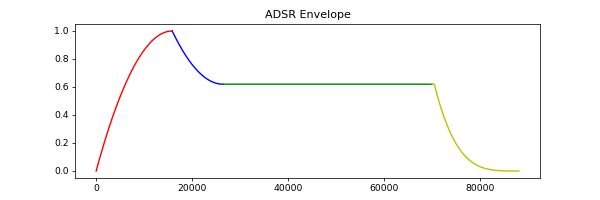

In [33]:
%matplotlib notebook
fig = plt.figure(figsize = (9,3))
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    ys = np.concatenate([attack(attackTime),
                         decay(decayTime,sustainLevel),
                         [sustainLevel]*44100,
                         release(releaseTime,sustainLevel)]).tolist()
    xs = range(0,len(ys))
    ax1.clear()
    ax1.set_title('ADSR Envelope', color='black')
    ax1.plot(xs[0:round(attackTime*fs)], 
             ys[0:round(attackTime*fs)], color = 'r')
    ax1.plot(xs[round(attackTime*fs):round((attackTime+decayTime)*fs)], 
             ys[round(attackTime*fs):round((attackTime+decayTime)*fs)], color = 'b')
    ax1.plot(xs[round((attackTime+decayTime)*fs):round((duration-releaseTime)*fs)], 
             ys[round((attackTime+decayTime)*fs):round((duration-releaseTime)*fs)], color = 'g')
    ax1.plot(xs[round((duration-releaseTime)*fs):round(duration*fs)], 
             ys[round((duration-releaseTime)*fs):round(duration*fs)], color = 'y')
ani = animation.FuncAnimation(fig, animate, blit = True)
plt.show()

## Efeitos Digitais [WIP]

### Filtro Passa-Baixa

In [29]:
def butter_lowpass(cutoff, fs=fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

## Key Event Read [WIP]

In [30]:
flag = 1

def on_press(key):
    global flag
    try:
        if key.char == '1' and flag:
            sd.play(sine(200, duration = 5))
            flag = 0
        elif key.char == '2' and flag:
            sd.play(sine(203, duration = 5))
            flag = 0
    except AttributeError:
        print('potato')

def on_release(key):
    global flag
    sd.stop()
    flag = 1
    if key == "1":
        print('potato')
    if key == Key.esc:
        # Stop listener
        return False
    
def start():
    with Listener(on_press=on_press,on_release=on_release) as listener: listener.join()